In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 11 16:39:06 2022

@author: ruijsch
"""

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 11 16:39:06 2022

@author: ruijsch
"""

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode, ParticleFile, ScipyParticle
from parcels import UnitConverter, Field, Variable
import numpy as np
import math
from datetime import timedelta, datetime
from datetime import timedelta as delta
from operator import attrgetter
from glob import glob
import copy
import xarray as xr
import matplotlib.pyplot as plt

import pandas as pd
from datetime import date, timedelta

#%%
#Load the data from Lorenz and define the indices
 
data_path_ocean = '/storage/shared/oceanparcels/input_data/MOi/'
# Load only a few time steps of the model output, to speed up this test simulation
ufiles = sorted(glob(data_path_ocean+'psy4v3r1/psy4v3r1-daily_U_*.nc'))[-3536:-3171]
vfiles = [f.replace('_U_', '_V_') for f in ufiles]
wfiles = [f.replace('_U_', '_W_') for f in ufiles][:4]
mesh_mask = data_path_ocean + 'domain_ORCA0083-N006/coordinates.nc'

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},

             }
variables = {'U': 'vozocrtx', 'V': 'vomecrty'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

# Madagascar indices
indices = {'lon': np.arange(3500,4321).tolist(),
            'lat': np.arange(900, 1600).tolist()}


In [3]:

#%%

data_path_wind = '/storage/shared/oceanparcels/output_data/data_Mikael/ERA5/wind/'
# Load only a few time steps of the model output, to speed up this test simulation
wind_files = sorted(glob(data_path_wind+'ERA5_global_wind_monthly_*.nc'))[156:168]

# the mesh mask comes from the ocean data path
mesh_mask = data_path_ocean + 'domain_ORCA0083-N006/coordinates.nc'


#%%

data_path_bathymetry = '/storage/shared/oceanparcels/input_data/MOi/'

maskfiles = data_path_bathymetry+'domain_ORCA0083-N006/bathymetry_ORCA12_V3.3.nc'

filenames_mask = {'mask': {'lon': maskfiles, 'lat': maskfiles, 'data': maskfiles}}

variables_mask = {'mask': 'mask'}
dimensions_mask = {'mask': {'lon': 'nav_lon', 'lat': 'nav_lat'}}

# Madagascar indices
indices_mask = {'lon': np.arange(3500,4321).tolist(),
            'lat': np.arange(900, 1600).tolist()}



     

In [4]:

#%%



coastfiles = 'distance_to_coast_22_04_22.nc'

filenames_coast = {'distance': {'lon': coastfiles, 'lat': coastfiles, 'data': coastfiles}}

variables_coast = {'distance': 'distance'}
dimensions_coast = {'distance': {'lon': 'lon', 'lat': 'lat'}}

# Madagascar indices -> it already has the right indices
# indices_coast = {'lon': np.arange(3500,4321).tolist(),
#             'lat': np.arange(900, 1600).tolist()}



In [5]:

boxfiles = 'box.nc'

filenames_coast = {'distance': {'lon': coastfiles, 'lat': coastfiles, 'data': coastfiles}}

variables_coast = {'distance': 'distance'}
dimensions_coast = {'distance': {'lon': 'lon', 'lat': 'lat'}}



#%%
#Make the fieldsets for the currents, wind, land/sea mask and the coast

# note the indices argument and the 'allow time extrapolation=True' to speed up simulation
fset_currents = FieldSet.from_nemo(filenames, variables, dimensions, indices=indices) #, allow_time_extrapolation=True)



In [9]:
xr.open_dataset(wind_files[0])


<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 62)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2013-01-01 ... 2013-01-31T12:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-13 20:57:10 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [15]:

#%%

withwind = 0.03  # wind factor of 3%
#withwind = 0  # wind factor of 0%
if withwind:
    windfiles = {'U': wind_files,
                 'V': wind_files}
    winddimensions = {'lon': 'longitude', 
                      'lat': 'latitude', 
                      'time': 'time'}
    windvariables = {'U': 'u10', 'V': 'v10'}
    # Madagascar indices
    indices_wind = {'lon': np.arange(0,300).tolist(),
               'lat': np.arange(300, 550).tolist()}
    fset_wind = FieldSet.from_nemo(windfiles, windvariables, winddimensions,indices=indices_wind)#, allow_time_extrapolation=True)
    fset_wind.U.set_scaling_factor(withwind)
    fset_wind.V.set_scaling_factor(withwind)
    


/nethome/6142060/parcels/parcels/field.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  timeslices = np.array(timeslices)
/nethome/6142060/parcels/parcels/field.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataFiles = np.concatenate(np.array(dataFiles))


In [16]:

#%%


fset_mask = FieldSet.from_nemo(filenames_mask, variables_mask, dimensions_mask, indices=indices_mask)
fset_coast = FieldSet.from_nemo(filenames_coast, variables_coast, dimensions_coast)

#%%

if withwind:
    fieldset = FieldSet(U=fset_currents.U + fset_wind.U, V=fset_currents.V + fset_wind.V)
else:
    fieldset = FieldSet(U=fset_currents.U, V=fset_currents.V)
    
fieldset.add_field(fset_mask.mask)
fieldset.add_field(fset_coast.distance)

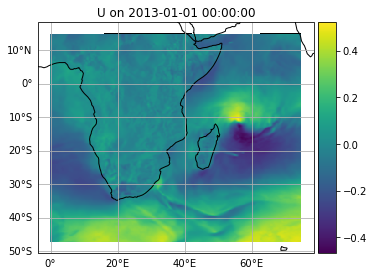

In [17]:
fieldset.U[1].show()

In [ ]:


day = 86400

#%%
#Custom particles and kernels

####################
# Custom Particles #
####################

class oceancc_particle(JITParticle):
    # add age of particle
    age = Variable('age', dtype=np.int32, initial=0.)
    stuck = Variable('stuck', dtype=np.int32, initial=0.)
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.
    first_lon = Variable('first_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the initial longitude
    first_lat = Variable('first_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the initial latitude.
    
    
fieldset.mask.data[:,:,650:] = 0
fieldset.mask.data[:,:,:220] = 0
fieldset.mask.data[:,:165,:] = 0
fieldset.mask.data[:,590:,:] = 0

X,Y = np.meshgrid(fieldset.mask.lon, fieldset.mask.lat)
p = fieldset.mask.data == 1
box_lon = X[p[0,:,:]]
box_lat = Y[p[0,:,:]]

# res = 0.01 #resolution in degrees

# minlon = 30
# maxlon = 58
# minlat = -33
# maxlat = -2
# grid = np.mgrid[int(minlon):int(maxlon):res,int(minlat):int(maxlat):res]+0.5

# n=grid[0].size

# lons_present = np.reshape(grid[0],n)
# lats_present = np.reshape(grid[1],n)

# Land = fieldset.mask
# dd = 1

# [lons_present,lats_present]=[np.array([lo for lo, la in zip(lons_present,lats_present) if Land[0,0,la,lo]==dd  ]),np.array([la for lo, la in zip(lons_present,lats_present) if Land[0,0,la,lo]==dd ])]

# np.save('lons_001_present.npy',(lons_present))
# np.save('lats_001_present.npy',(lats_present))

lonss = np.load('lons_001_present.npy')
latss = np.load('lats_001_present.npy')
depths = np.ones(np.shape(lonss)[0])*0.5


#%%
####################
# Particle Kernels #
####################

def DeleteParticle(particle, fieldset, time):
    particle.delete()

def PrintLoc(particle, fieldset, time):
    print('(lon, lat): (%.4f, %.4f)'%(particle.lon, particle.lat))
    
# Delete particles out of bounds
def deleteParticle(particle, fieldset, time):
    particle.delete()

# Particle ageing kernel
def ageingParticle(particle, fieldset, time): #age of the particle (in dt = 60 min) 
    particle.age += 1 #so age 1 = 60 minutes ( = dt)
    
def stuckParticle(particle, fieldset, time):
    if (particle.prev_lon == particle.lon) and (particle.prev_lat == particle.lat):
        particle.stuck += 1
    # Set the stored values for next iteration.
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat

# Delete old particles
def killSwitch(particle, fieldset, time):
    if particle.age >= 24*30: #if particle is older than 30 days
        particle.delete() #delete it


def initloc(particle, fieldset, time):
    if time == 0:
        particle.first_lon = particle.lon
        particle.first_lat = particle.lat

# Delete old particles
# by repositioning them to their initial location
def killSwitch2(particle, fieldset, time):
    if particle.age >= 24*30:
        particle.lon = particle.first_lon
        particle.lat = particle.first_lat
        particle.age = 0
        particle.stuck = 0


def AdvectionRK4_Land(particle, fieldset, time):  
    if fieldset.mask[particle] == 0: #or fieldset.distance[particle] < 10:
    #if fieldset.distance[particle] <= 10:
        #land
        particle.lon = particle.prev_lon
        particle.lat = particle.prev_lat 
        
            
    if fieldset.mask[particle] == 1: # and fieldset.distance[particle] > 10:
    #if fieldset.distance[particle] > 10:
        #ocean
        (u1, v1) = fieldset.UV[particle]
        lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
        (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1, particle]
        lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
        (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2, particle]
        lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
        (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3, particle]
        particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt

days = np.arange(0,370,5)       
#days = [360,365]

for day in days:
    print(day)
    pset = ParticleSet.from_list(fieldset=fieldset, pclass=oceancc_particle, lon=lonss, lat=latss, depth = depths, time = 60*60*24*day)


    kernels = pset.Kernel(ageingParticle) + pset.Kernel(killSwitch) + pset.Kernel(stuckParticle) +  pset.Kernel(AdvectionRK4_Land)

    output_file = pset.ParticleFile(name='2022_11_20_present_day_2013_whole_grid_001_windage_3_day'+str(day)+'.nc', 
                             outputdt=timedelta(hours=3))#, convert_at_end=True)
    

    pset.execute(pyfunc=kernels, output_file=output_file, runtime=timedelta(days=5), dt=timedelta(minutes=60), verbose_progress=True, recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

    output_file.close()

    print('done')   